In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import pickle

data = pd.read_csv('datasets/train.csv')
df = data.copy()

In [176]:
df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked', 'Fare'], axis=1, inplace=True)

In [177]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [178]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594
std,0.486592,0.836071,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 41.9+ KB


In [180]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Age'] = df['Age'].astype('int64')

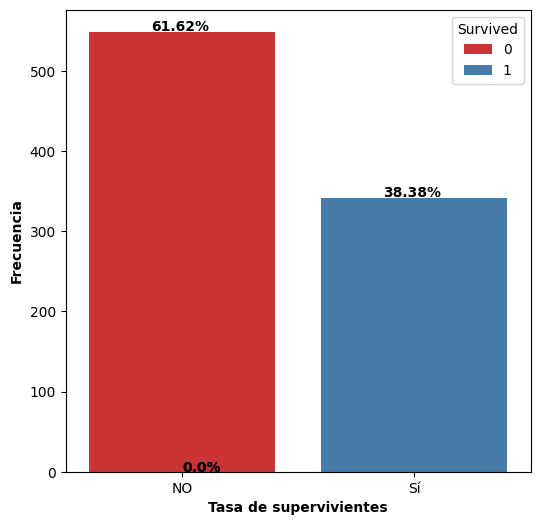

In [181]:
# Representación Gráfica de la distribución de la variable objeto
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.countplot(data=df, x='Survived', palette='Set1', hue='Survived')
plt.xlabel('Tasa de supervivientes', weight='bold')
plt.xticks(np.arange(2), ['NO', 'Sí'])

for p in ax.patches:
    ax.annotate(f'{round(p.get_height() / len(df) * 100, 2)}%', xy=(p.get_x() + p.get_width() / 3, p.get_height() * 1.002), weight='bold')

plt.ylabel('Frecuencia', weight='bold')
plt.show()

In [182]:
df_survived = df[df['Survived'] == 1]

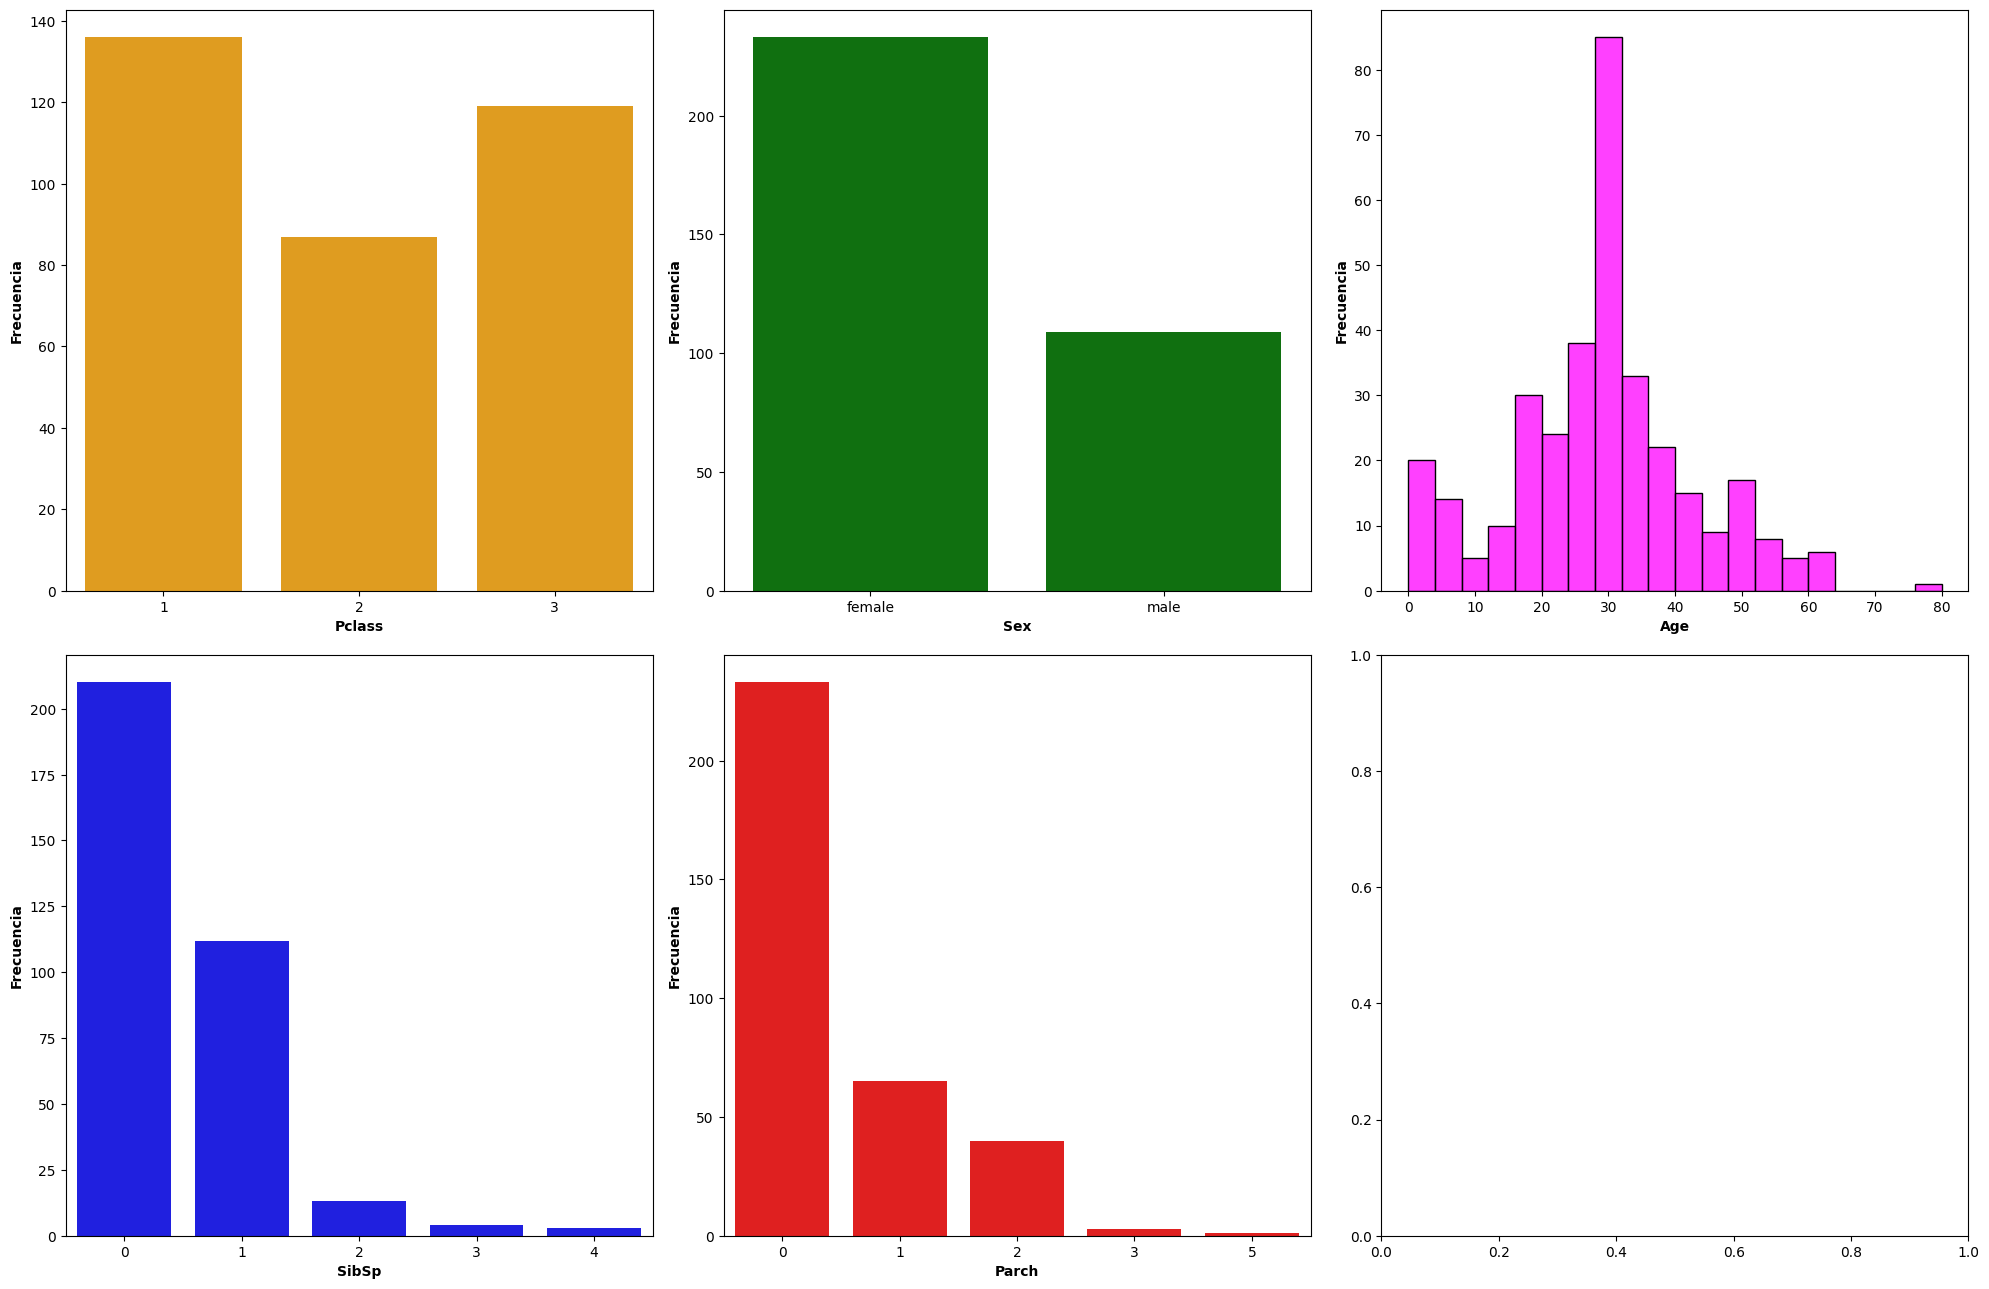

In [183]:
# Distribución de las variables numéricas con valores enteros
colors = ['orange', 'green', 'magenta', 'blue', 'red']
labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 13))

for i,col in enumerate(labels):
    if col != 'Survived':

        if col == 'Age':
            plt.subplot(2,3,i+1)
            axi = sns.histplot(x=df_survived[col], color=colors[i], stat='count')
            plt.xlabel(labels[i], weight='bold')
            plt.ylabel('Frecuencia', weight='bold')
        else:
            plt.subplot(2,3,i+1)
            axi = sns.countplot(x=df_survived[col], color=colors[i])
            plt.xlabel(labels[i], weight='bold')
            plt.ylabel('Frecuencia', weight='bold')

plt.tight_layout(pad=1.1)
plt.show()

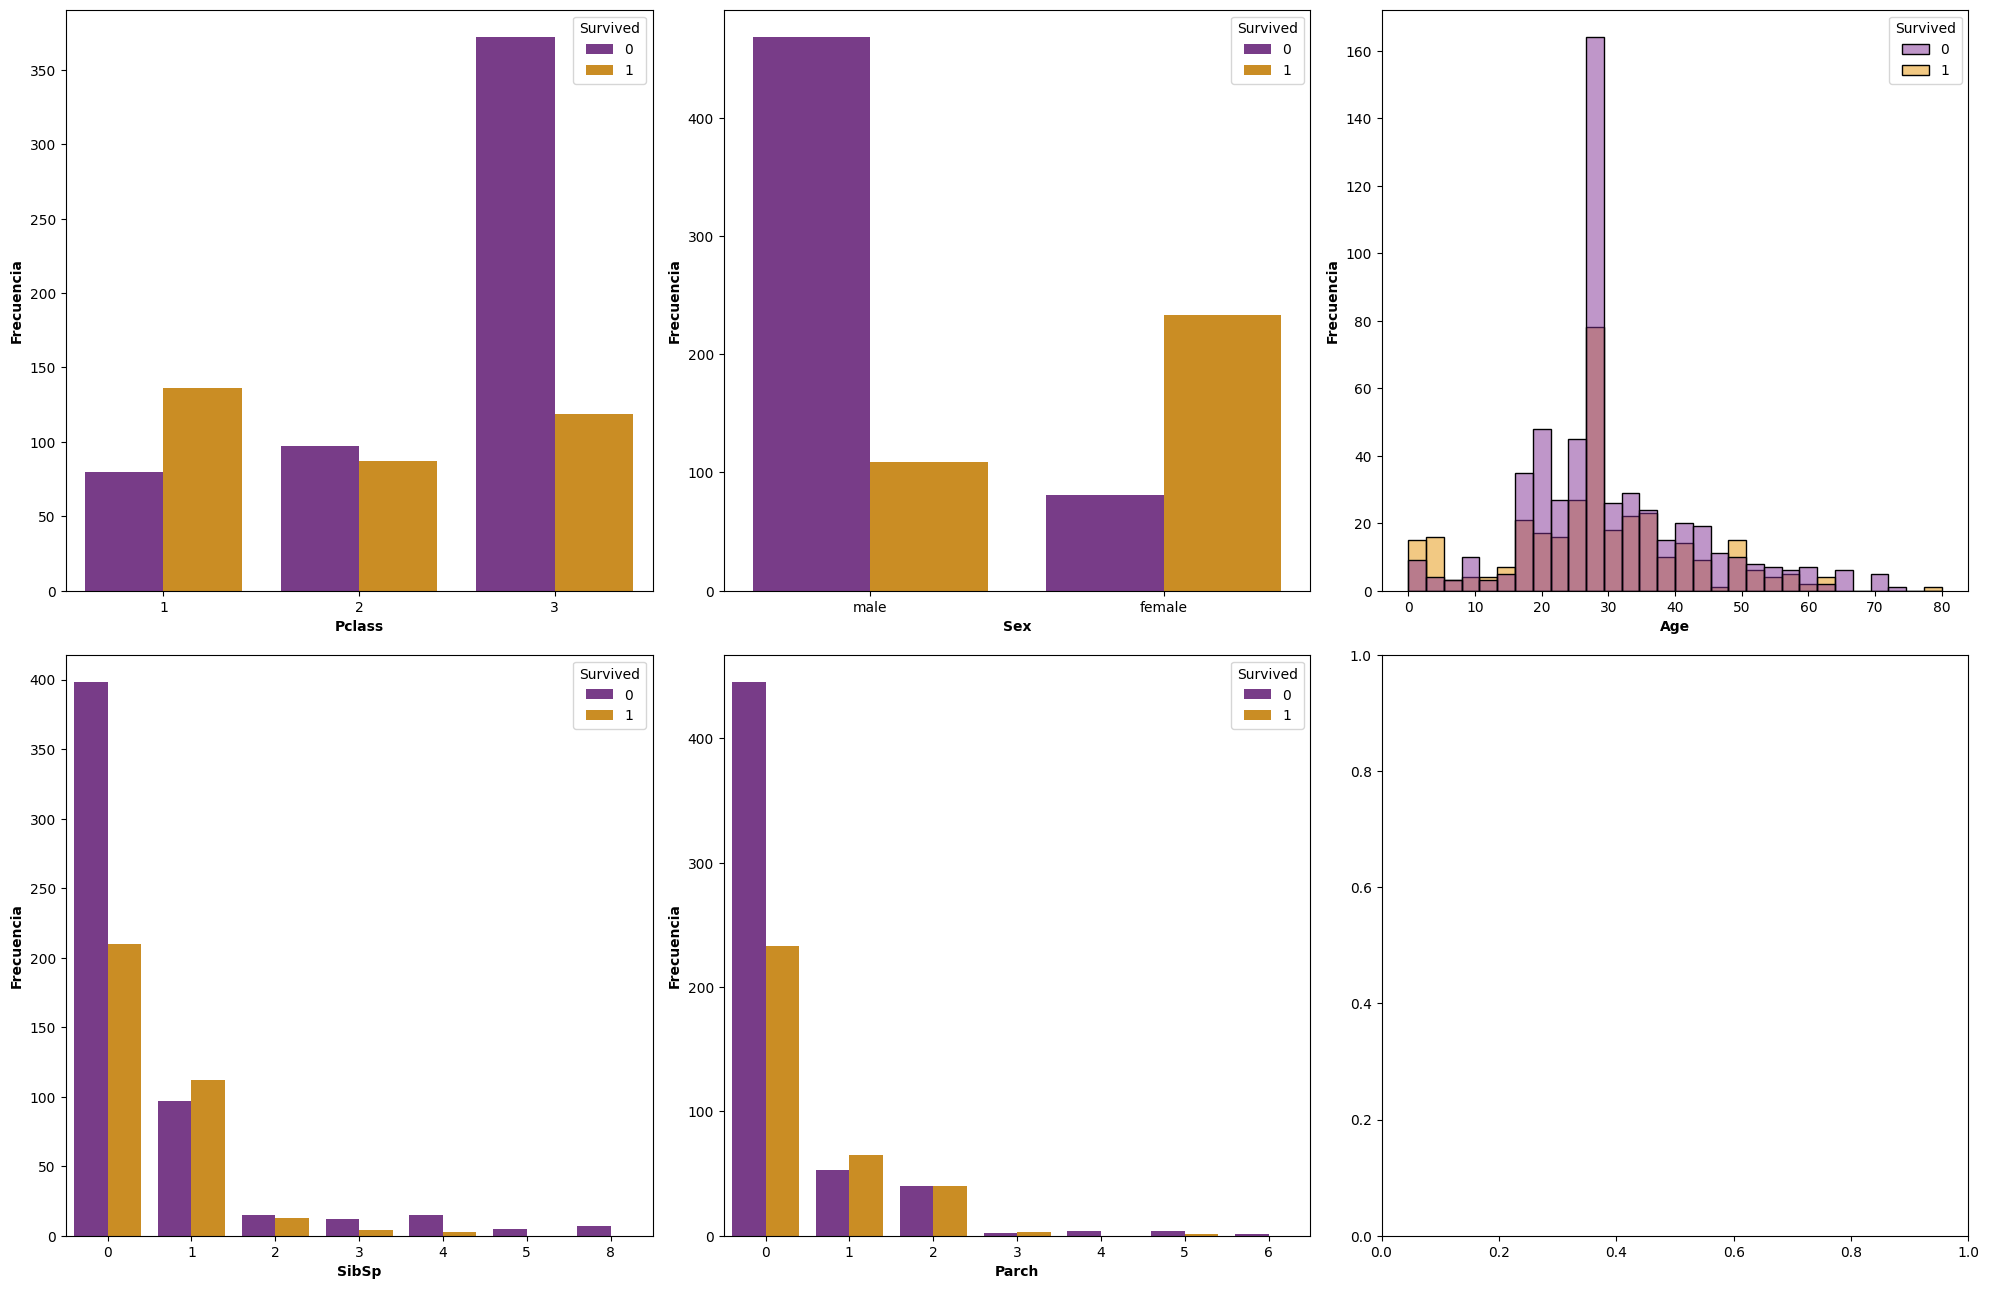

In [184]:
# Distribución de las variables numéricas discretas respecto la variable objeto
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 13))

labels = df.columns.drop('Survived')

for i,col in enumerate(labels):
    if col == 'Age':
        plt.subplot(2,3,i+1)
        axi = sns.histplot(data=df, x=col, hue='Survived', palette='CMRmap', stat='count')
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')
    else:
        plt.subplot(2,3,i+1)
        axi = sns.countplot(data=df, x=col, hue='Survived', palette='CMRmap')
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')

plt.tight_layout(pad=1.1)
plt.show()

### Analisis de correlación entre variables

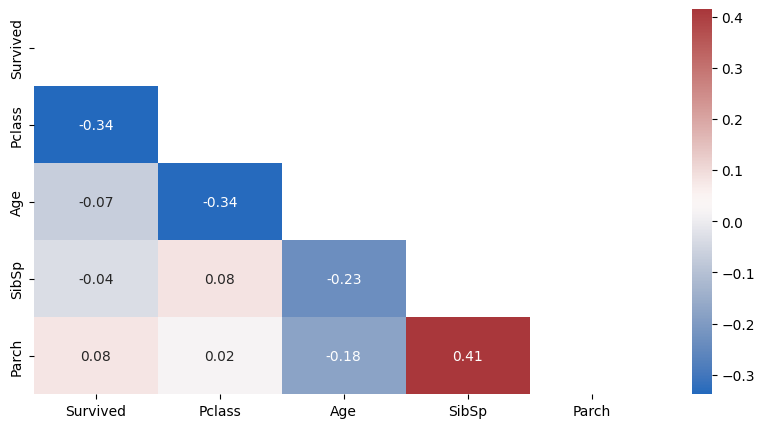

In [185]:
# Mostramos el gráfico de correlación que existe entre las variables
corr = df.select_dtypes(include=['float', 'int']).corr()
plt.subplots(figsize=(10, 5))
ax = sns.heatmap(corr, annot=True, cmap='vlag', cbar=True, fmt='.2f', mask=np.triu(corr))
plt.show()

### Creamos columnas de las variables categoricas disfrazadas de numericas

In [186]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.544332,0.523008,0.381594
std,0.486592,0.836071,13.013778,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000
50%,0.000000,3.000000,29.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000


In [187]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass'], prefix=['Sex', 'Pclass'], prefix_sep='_', dtype='int32')
df.head()

,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22,1,0,0,1,0,0,1
1,1,38,1,0,1,0,1,0,0
2,1,26,0,0,1,0,0,0,1
3,1,35,1,0,1,0,1,0,0
4,0,35,0,0,0,1,0,0,1


# Elección y entrenamiento del modelo

In [188]:
SEED = 42

In [189]:
X = df.drop('Survived', axis=1).values
y = df['Survived'].values

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [191]:
kf = KFold(n_splits=70, shuffle=True, random_state=SEED)
rf = RandomForestClassifier()
gs = RandomizedSearchCV(rf, param_distributions={'max_depth': range(2, 10),
                                                 "n_estimators":range(10, 200, 10), "random_state":range(1, 50)}, cv=kf, scoring='accuracy', n_jobs=-1, refit=True)

In [192]:
gs.fit(X_train, y_train)
gs.best_params_


{'random_state': 11, 'n_estimators': 140, 'max_depth': 5}

In [193]:
gs.score(X_test, y_test)

0.8156424581005587

_mejores valores_:{'random_state': 40, 'n_estimators': 70, 'max_depth': 4}

In [194]:
pickle.dump(gs, open('models/titanic_model.pkl', 'wb'))